In [29]:
# Written by: Mohamat Eirban Ali
# A general function that uses K-Fold validation for Neural Network modelling for either classification or regression problem
# The function is also demonstrated with the Red Wine and Abalone dataset

In [30]:

import pandas as pd

#Read the dataset
df = pd.read_csv("Downloads/winequality-red.csv",sep = ';')
output_directory = "Downloads"
print(df)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  

In [31]:
#Pre- processing
import numpy as np
from sklearn import preprocessing
import pandas as pd
import os
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

y = df.quality
#y_binary = to_categorical(y)
X = df.drop('quality', axis=1)

X_scaled = preprocessing.scale(X)

dummies1 = pd.get_dummies(df.quality) # Classification
products = dummies1.columns

In [32]:
# General Function Cross Validation
def crossVal(X, Y, K, prob):
    """
    For given X and Y, run k cross-validation on them

    Arguments:
    X -- Features [predictors]
    Y -- Target Output
    K -- Number of Folds
    prob -- "classification" or "regression" problem

    Return:
    Y_Output -- Dataframe containing actual and predicted output values
    """
    
    if prob == "classification":
        # Cross-validate
        kf = StratifiedKFold(K, shuffle=True, random_state=42) # Use for StratifiedKFold classification
    
    
    
    
        oos_y = []
        oos_pred = []
        fold = 0
    
        for train, test in kf.split(X,Y): # Must specify y StratifiedKFold for 
            fold+=1
            print(f"Fold #{fold}")
        
            x_train = X[train]
        
            x_test = X[test]
        
        
            dummies = pd.get_dummies(Y[train])
            products = dummies.columns
            y_train = dummies.values

            dummies = pd.get_dummies(Y[test])
            products = dummies.columns
            y_test = dummies.values

            model = Sequential()
            model.add(Dense(150, input_dim=X.shape[1], activation='relu', activity_regularizer=regularizers.l1(1e-4))) # Hidden 1
            model.add(BatchNormalization())
            model.add(Dropout(0.25))
            model.add(Dense(75, activation='relu', activity_regularizer=regularizers.l2(1e-4))) # Hidden 2
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(25, activation='relu', activity_regularizer=regularizers.l1(1e-4))) # Hidden 3
            model.add(Dense(y_train.shape[1],activation='softmax')) # Output
            model.compile(loss='categorical_crossentropy', optimizer='adam')

            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=40, verbose=1, mode='auto',
            restore_best_weights=True)
            model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=150)

            pred = model.predict(x_test)

            oos_y.append(y_test)
            pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
            oos_pred.append(pred)  

            # Measure this fold's accuracy
            y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
            score = metrics.accuracy_score(y_compare, pred)
            print(f"Fold score (accuracy): {score}")

            #Save weights for each fold
            model.save(os.path.join(output_directory, 'fold_{}_modelClass.hdf5'.format(fold)))
        
        # Build the oos prediction list and calculate the error.
        oos_y = np.concatenate(oos_y)
        oos_pred = np.concatenate(oos_pred)
        oos_y = np.argmax(oos_y,axis=1) # For accuracy calculation.
        
        score = metrics.accuracy_score(oos_y, oos_pred)
        print(f"Final score (accuracy): {score}")  
        
    elif prob == "regression":
    
        # Cross-Validate
        kf = KFold(K, shuffle=True, random_state=42) # Use for KFold classification

        oos_y = []
        oos_pred = []
    
        fold = 0
        for train, test in kf.split(X): 
            fold+=1
            print(f"Fold #{fold}")
        
            x_train = X[train]
            y_train = Y[train]
            x_test = X[test]
            y_test = Y[test]

            model = Sequential()
            model.add(Dense(150, input_dim=X.shape[1], activation='relu', activity_regularizer=regularizers.l2(1e-4))) # Hidden 1
            model.add(BatchNormalization())
            model.add(Dropout(0.25))
            model.add(Dense(75, activation='relu', activity_regularizer=regularizers.l2(1e-4))) # Hidden 2
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(25, activation='relu', activity_regularizer=regularizers.l1(1e-4))) # Hidden 3
            model.add(Dense(1)) # Output
            model.compile(loss='mean_squared_error', optimizer='adam')

            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=40, verbose=1, mode='auto',
            restore_best_weights=True)
            model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=150)

            pred = model.predict(x_test)
            oos_y.append(y_test)
            oos_pred.append(pred)
            
            # Measure this fold's RMSE
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print(f"Fold score (RMSE): {score}")

           

            #Save weights for each fold
            model.save(os.path.join(output_directory, 'fold_{}_modelReg.hdf5'.format(fold)))
        
        # Build the oos prediction list and calculate the error.
        oos_y = np.concatenate(oos_y)
        oos_pred = np.concatenate(oos_pred)
        score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
        print(f"Final, out of sample score (RMSE): {score}")
        
    return oos_y, oos_pred


In [33]:
true, pred = crossVal(X_scaled, y, 5, "classification")



Fold #1
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Fold score (accuracy): 0.61875
Fold #2
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Fold score (accuracy): 0.64375
Fold #3
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Fold score (accuracy): 0.628125
Fold #4
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Fold score (accuracy): 0.634375
Fold #5
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Fold score (accuracy): 0.5924764890282131
Final score (accuracy): 0.6235146966854284


In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  0   1   8   1   0   0]
 [  0   0  39  13   1   0]
 [  0   3 522 149   7   0]
 [  0   1 203 400  34   0]
 [  0   0  10 113  75   1]
 [  0   0   0  10   8   0]]
Normalized confusion matrix
[[0.   0.1  0.8  0.1  0.   0.  ]
 [0.   0.   0.74 0.25 0.02 0.  ]
 [0.   0.   0.77 0.22 0.01 0.  ]
 [0.   0.   0.32 0.63 0.05 0.  ]
 [0.   0.   0.05 0.57 0.38 0.01]
 [0.   0.   0.   0.56 0.44 0.  ]]


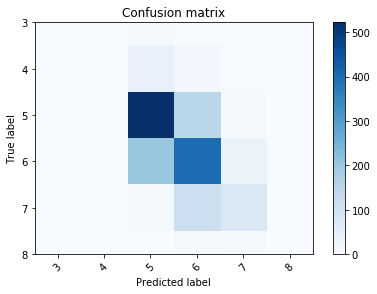

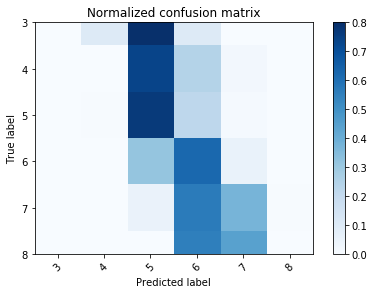

In [35]:

# Compute confusion matrix
cm = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')

plt.show()

In [36]:
from sklearn.preprocessing import MinMaxScaler
abalone_data = pd.read_csv("Downloads/abalone.data.csv")

abalone_data['Sex'] = abalone_data['Sex'].map({'M': 0, 'F': 1, 'I':2})
abalone_data_scaled = preprocessing.scale(abalone_data)
Y = abalone_data_scaled[:,8]
X = abalone_data_scaled[:,:-1]

In [37]:
trueab, predab = crossVal(X, Y, 5, "regression")

Fold #1
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
Fold score (RMSE): 0.6471474119531415
Fold #2
Fold score (RMSE): 0.621342025013423
Fold #3
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Fold score (RMSE): 0.6809619272812147
Fold #4
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
Fold score (RMSE): 0.6652717923217943
Fold #5
Restoring model weights from the end of the best epoch.
Epoch 00136: early stopping
Fold score (RMSE): 0.5799330420399639
Final, out of sample score (RMSE): 0.639916683754419


In [38]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

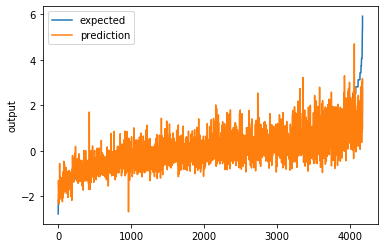

In [39]:
# Plot the chart
chart_regression(predab.flatten(),trueab)